# Understanding Hired Rides in NYC

## Project Setup

In [2]:
# all import statements needed for the project

import os
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import re
import geopandas as gpd
from math import ceil
from urllib.parse import unquote
import glob
from sqlalchemy import text
import folium
from folium.plugins import HeatMap

In [3]:

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

dataset_directory = "/Users/shaoziheng/Desktop/4501/project/datasets"
TAXI_ZONES_DIR = "/Users/shaoziheng/Desktop/4501/project/datasets/taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "/Users/shaoziheng/Desktop/4501/project/datasets/weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [4]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [5]:
def load_taxi_zones(shapefile):
    """
    Load and preprocess a shapefile containing taxi zone data.

    Args:
        shapefile (str): Path to the shapefile containing taxi zone boundaries. 
                         The shapefile must include `LocationID` or similar 
                         geographic attributes.
                        
    Returns:
        A GeoDataFrame with added `longitude` and 
        `latitude` columns corresponding to the centroids
        of the taxi zones.
    """
    g = gpd.read_file(shapefile)
    g = g.to_crs(4326)
    g['longitude'] = g.centroid.x
    g['latitude'] = g.centroid.y
    return g

### Web scraping links for downloading files

In [6]:
# Fetch URL from the TLC page
def get_all_urls_from_tlc_page(taxi_page):
    """
    Fetch the HTML content from the provided TLC page URL and parse it with BeautifulSoup.

    Args:
        taxi_page (str): The URL of the TLC webpage containing the data links.

    Returns:
        BeautifulSoup: A parsed BeautifulSoup object containing the HTML content 
                       of the webpage for further processing.
    """
    response = requests.get(taxi_page)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch page content: {response.status_code}")
    soup = BeautifulSoup(response.text, "html.parser")
    return soup

In [7]:
# Extract URLs for yellow taxi and HVFHV data from the TLC page

def filter_parquet_urls(soup):
    """
    Extract URLs for yellow taxi and HVFHV trip data in Parquet format from the TLC webpage.

    Args:
        soup (BeautifulSoup): A BeautifulSoup object containing the parsed HTML of the TLC webpage.

    Returns:
        tuple: A tuple containing two lists:
            - yellow_taxi_links (list): List of URLs for yellow taxi Parquet files.
            - hvfhv_links (list): List of URLs for HVFHV Parquet files.

    Description:
        - Identifies links that match the naming pattern for yellow taxi and HVFHV trip data.
        - Decodes encoded characters (e.g., `%20` -> space) in the URLs.
        - Filters links based on file naming conventions for years 2020-2024.
    """
    yellow_taxi_links = []
    yellow_links = soup.find_all('a', {'href': re.compile(r"yellow_tripdata_202[0-3]-\d{2}\.parquet|yellow_tripdata_2024-(0[1-8])\.parquet")})
    for link in yellow_links:
        url = link['href'].strip()  # Remove leading/trailing spaces
        url = unquote(url)  # Decode any encoded characters like %20
        yellow_taxi_links.append(url)
        
    hvfhv_links = []
    hvfhv_links_soup = soup.find_all('a', {'href': re.compile(r"fhvhv_tripdata_202[0-3]-\d{2}\.parquet|fhvhv_tripdata_2024-(0[1-8])\.parquet")})
    for link in hvfhv_links_soup:
        url = link['href'].strip()  # Remove leading/trailing spaces
        url = unquote(url)  # Decode any encoded characters like %20
        hvfhv_links.append(url)
        
    return yellow_taxi_links, hvfhv_links


In [8]:
# download  the Yellow Taxi & High-Volume For-Hire Vehicle (HVFHV) trip data parquet files and save them to directory

def download_parquet_file(urls, output_directory):
    """
    Downloads Parquet files from a list of URLs and saves them to the specified directory.

    Args:
        urls (list): List of URLs to download.
        output_directory (str): Path to the directory where files will be saved.

    Raises:
        Exception: If a file fails to download.
    """
    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    for url in urls:
        file_name = os.path.basename(url)
        output_path = os.path.join(output_directory, file_name)

        try:
            print(f"Downloading {url}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raise an error for failed requests

            # Write the file content to disk
            with open(output_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:  # Filter out keep-alive chunks
                        file.write(chunk)

            print(f"Saved to {output_path}")
        except Exception as e:
            print(f"Failed to download {url}: {e}")

In [9]:
soup=get_all_urls_from_tlc_page(TLC_URL)
yellow_taxi_links, hvfhv_links = filter_parquet_urls(soup)

In [10]:
# Download Yellow Taxi files
download_parquet_file(yellow_taxi_links, os.path.join(dataset_directory, "yellow_tripdata"))

# Download Uber HVFHV files
download_parquet_file(hvfhv_links, os.path.join(dataset_directory, "fhvhv_tripdata"))


Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-01.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-02.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-03.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-04.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-05.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-06.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-07.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-08.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-01.parquet
Saved to /Users/shaoziheng/Desktop/4501/project/dataset

### Calculate Sample Size

In [11]:
# calculate sample size using Cochran's formula with 95% CI and 5% marginal error.

def calculate_sample_size(population, confidence_level=0.95, margin_of_error=0.05):
    """
    Calculate the sample size using Cochran's formula, considering finite population correction.

    Args:
        population (int): Total population size for which the sample size needs to be calculated.
        confidence_level (float): Desired confidence level (default is 0.95 for 95% CI).
        margin_of_error (float): Allowable margin of error (default is 0.05 for 5%).

    Returns:
        int: The calculated sample size, rounded up to the nearest integer.

    Formula:
        Cochran's formula for infinite population:
            n0 = (Z^2 * p * (1 - p)) / e^2
        Where:
            - Z: Z-score corresponding to the confidence level.
            - p: Estimated proportion of the population (default: 0.5 for maximum variability).
            - e: Margin of error.

        Finite population correction for population size N:
            n = n0 / (1 + (n0 - 1) / N)
    """
    Z = {0.9: 1.645, 0.95: 1.96, 0.99: 2.576}[confidence_level]
    p = 0.5
    e = margin_of_error
    sample_size = (Z**2 * p * (1 - p)) / e**2
    if population < 1e6:  # Finite population correction
        sample_size = sample_size / (1 + (sample_size - 1) / population)
    return ceil(sample_size)

### Process Taxi Data

In [12]:
def apply_cleaning_and_combine_taxi(input_directory, output_file):
    """
    Apply the `clean_taxi_month` function to all Parquet files in the input directory
    and combine the cleaned and sampled files into a single large Parquet file.

    Args:
        input_directory (str): Path to the directory containing the Parquet files.
        output_file (str): Path to save the combined cleaned Parquet file.

    Returns:
        None
    """
    # Get all Parquet files in the directory
    parquet_files = glob.glob(f"{input_directory}/*.parquet")
    
    all_cleaned_data = []  # To store all cleaned DataFrames

    # Apply cleaning to each file
    for file_path in parquet_files:
        print(f"Processing file: {file_path}")
        
        # load taxi zone data
        taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
        taxi_zones = taxi_zones[['LocationID', 'longitude', 'latitude', 'zone', 'borough']]
        df = pd.read_parquet(file_path)
        lat_map = dict(zip(taxi_zones['LocationID'], taxi_zones['latitude']))
        lon_map = dict(zip(taxi_zones['LocationID'], taxi_zones['longitude']))
        
        # Apply the transformations from clean_taxi_month
        df['pickup_latitude'] = df['PULocationID'].map(lat_map)
        df['pickup_longitude'] = df['PULocationID'].map(lon_map)
        df['dropoff_latitude'] = df['DOLocationID'].map(lat_map)
        df['dropoff_longitude'] = df['DOLocationID'].map(lon_map)

        # remove invalid location IDs - drop rows where any of the values are missing 
        df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])
        
        # Filter out invalid data points (non-positive fare, tip, passenger, trip distance)
        df = df[(df['fare_amount'] > 0) & (df['tip_amount'] >= 0) & 
                (df['total_amount'] >= 0) & (df['passenger_count'] > 0) & 
                (df['trip_distance'] > 0)]
        

        # remove rows where pickup and dropoff latitudes/longitudes are the same or very close
        df = df[(df['pickup_latitude'] != df['dropoff_latitude']) & 
                (df['pickup_longitude'] != df['dropoff_longitude']) & 
                (abs(df['pickup_longitude'] - df['dropoff_longitude']) > 0.001)]
        
        # Normalize column names
        df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]

        # Remove trips that start and/or end outside of the NEW_YORK_BOX
        NEW_YORK_BOX_COORDS = [(40.560445, -74.242330), (40.908524, -73.717047)]
        df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & 
                (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0]) & 
                (df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & 
                (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
        df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & 
                (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0]) & 
                (df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & 
                (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
        
        # remove unnecessary columns 
        df = df[['tpep_pickup_datetime','tpep_dropoff_datetime','fare_amount','tip_amount', 'extra', 'improvement_surcharge',
                  'congestion_surcharge', 'airport_fee', 'mta_tax', 'tolls_amount', 'pickup_latitude','pickup_longitude',
                 'dropoff_latitude','dropoff_longitude', 'trip_distance'
                ]]
        
        # Convert data types after filtering
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')
        df['fare_amount'] = df['fare_amount'].astype(float, errors='ignore')
        df['tip_amount'] = df['tip_amount'].astype(float, errors='ignore')
        df['extra'] = df['extra'].astype(float, errors='ignore')
        df['improvement_surcharge'] = df['improvement_surcharge'].astype(float, errors='ignore')
        df['congestion_surcharge'] = df['congestion_surcharge'].astype(float, errors='ignore')
        df['airport_fee'] = df['airport_fee'].fillna(0).astype(float, errors='ignore')
        df['mta_tax'] = df['mta_tax'].astype(float, errors='ignore')
        df['tolls_amount'] = df['tolls_amount'].astype(float, errors='ignore')
        df['pickup_latitude'] = df['pickup_latitude'].astype(float, errors='ignore')
        df['pickup_longitude'] = df['pickup_longitude'].astype(float, errors='ignore')
        df['dropoff_latitude'] = df['dropoff_latitude'].astype(float, errors='ignore')
        df['dropoff_longitude'] = df['dropoff_longitude'].astype(float, errors='ignore')
        df['trip_distance'] = df['trip_distance'].astype(float, errors='ignore')
        
        
        
        # calculate sample size and generate sampled_df
        population_size = len(df)
        sample_size = calculate_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05)
        sampled_df = df.sample(n=sample_size, random_state=42)

        # Append cleaned and sampled data to the list
        all_cleaned_data.append(sampled_df)
        print(f"Finished processing file: {file_path}")
    
    # Combine all cleaned DataFrames
    combined_df = pd.concat(all_cleaned_data, ignore_index=True)
    print(f"Combined all cleaned data into a single DataFrame with {len(combined_df)} rows.")

    # Save the combined DataFrame to a Parquet file
    combined_df.to_parquet(output_file, index=False)
    print(f"Saved combined data to {output_file}")


In [13]:
taxi_input_directory = f"{dataset_directory}/yellow_tripdata"
taxi_output_file = f"{dataset_directory}/combined_taxi_data.parquet"
apply_cleaning_and_combine_taxi(taxi_input_directory, taxi_output_file)

Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2020-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2024-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2022-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2021-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Finished processing file: /Users/shaoziheng/Desktop/4501/project/datasets/yellow_tripdata/yellow_tripdata_2023-03.parquet
Combined all cleaned data into a single DataFrame with 21555 rows.
Saved combined data to /Users/shaoziheng/Desktop/4501/project/datasets/combined_taxi_data.parquet


In [14]:
taxi_data=pd.read_parquet(taxi_output_file)

In [15]:
taxi_data

,tpep_pickup_datetime,tpep_dropoff_datetime,fare_amount,tip_amount,extra,improvement_surcharge,congestion_surcharge,airport_fee,mta_tax,tolls_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance
0,2023-06-27 16:50:19,2023-06-27 16:55:31,6.5,1.00,2.5,1.0,2.5,0.0,0.5,0.00,40.756687,-73.972356,40.758027,-73.977698,0.70
1,2023-06-28 14:01:22,2023-06-28 14:16:21,19.8,0.00,0.0,1.0,2.5,0.0,0.5,0.00,40.706808,-74.007496,40.734575,-74.002875,3.73
2,2023-06-09 20:04:55,2023-06-09 20:12:42,9.3,3.16,2.5,1.0,2.5,0.0,0.5,0.00,40.748427,-73.999917,40.735035,-74.008984,1.06
3,2023-06-04 01:03:00,2023-06-04 01:08:15,6.5,2.00,3.5,1.0,2.5,0.0,0.5,0.00,40.734575,-74.002875,40.723888,-74.001537,0.70
4,2023-06-30 08:07:36,2023-06-30 08:13:14,7.9,1.00,2.5,1.0,2.5,0.0,0.5,0.00,40.780436,-73.957011,40.790010,-73.945750,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21550,2023-03-01 22:21:47,2023-03-01 22:36:55,19.8,6.27,1.0,1.0,2.5,0.0,0.5,6.55,40.753512,-73.988786,40.729506,-73.949540,3.94
21551,2023-03-01 15:57:02,2023-03-01 16:06:07,10.0,0.00,0.0,1.0,0.0,0.0,0.5,0.00,40.818257,-73.940771,40.801169,-73.937345,0.88
21552,2023-03-06 17:46:31,2023-03-06 17:53:27,8.6,0.00,2.5,1.0,2.5,0.0,0.5,0.00,40.732579,-73.994305,40.742278,-73.996971,1.07
21553,2023-03-22 17:44:43,2023-03-22 17:55:28,10.7,0.00,5.0,1.0,2.5,0.0,0.5,0.00,40.775965,-73.987645,40.762252,-73.989844,1.10


In [16]:
taxi_data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,fare_amount,tip_amount,extra,improvement_surcharge,congestion_surcharge,airport_fee,mta_tax,tolls_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance
0,2023-06-27 16:50:19,2023-06-27 16:55:31,6.5,1.00,2.5,1.0,2.5,0.0,0.5,0.0,40.756687,-73.972356,40.758027,-73.977698,0.70
1,2023-06-28 14:01:22,2023-06-28 14:16:21,19.8,0.00,0.0,1.0,2.5,0.0,0.5,0.0,40.706808,-74.007496,40.734575,-74.002875,3.73
2,2023-06-09 20:04:55,2023-06-09 20:12:42,9.3,3.16,2.5,1.0,2.5,0.0,0.5,0.0,40.748427,-73.999917,40.735035,-74.008984,1.06
3,2023-06-04 01:03:00,2023-06-04 01:08:15,6.5,2.00,3.5,1.0,2.5,0.0,0.5,0.0,40.734575,-74.002875,40.723888,-74.001537,0.70
4,2023-06-30 08:07:36,2023-06-30 08:13:14,7.9,1.00,2.5,1.0,2.5,0.0,0.5,0.0,40.780436,-73.957011,40.790010,-73.945750,0.80


In [17]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21555 entries, 0 to 21554
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   21555 non-null  datetime64[ns]
 1   tpep_dropoff_datetime  21555 non-null  datetime64[ns]
 2   fare_amount            21555 non-null  float64       
 3   tip_amount             21555 non-null  float64       
 4   extra                  21555 non-null  float64       
 5   improvement_surcharge  21555 non-null  float64       
 6   congestion_surcharge   21555 non-null  float64       
 7   airport_fee            21555 non-null  float64       
 8   mta_tax                21555 non-null  float64       
 9   tolls_amount           21555 non-null  float64       
 10  pickup_latitude        21555 non-null  float64       
 11  pickup_longitude       21555 non-null  float64       
 12  dropoff_latitude       21555 non-null  float64       
 13  d

In [18]:
taxi_data.describe()

,tpep_pickup_datetime,tpep_dropoff_datetime,fare_amount,tip_amount,extra,improvement_surcharge,congestion_surcharge,airport_fee,mta_tax,tolls_amount,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance
count,21555,21555,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000,21555.000000
mean,2022-05-02 02:22:55.033170688,2022-05-02 02:40:03.177824256,15.498320,2.817350,1.273732,0.553250,2.326374,0.090478,0.498056,0.469210,40.753237,-73.967072,40.755621,-73.971460,3.319831
min,2020-01-01 03:06:55,2020-01-01 03:13:30,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.576961,-74.174000,40.571769,-74.174000,0.010000
25%,2021-03-01 17:26:52,2021-03-01 17:35:34,7.500000,0.180000,0.000000,0.300000,2.500000,0.000000,0.500000,0.000000,40.740438,-73.989844,40.740337,-73.989844,1.160000
50%,2022-05-01 11:01:50,2022-05-01 11:21:35,11.000000,2.260000,1.000000,0.300000,2.500000,0.000000,0.500000,0.000000,40.758027,-73.977698,40.758027,-73.977698,1.870000
75%,2023-07-01 00:33:29.500000,2023-07-01 00:48:51.500000,17.000000,3.560000,2.500000,1.000000,2.500000,0.000000,0.500000,0.000000,40.773633,-73.965146,40.774375,-73.959635,3.320000
max,2024-08-31 21:58:30,2024-08-31 22:21:51,159.800000,99.990000,11.750000,1.000000,2.500000,1.750000,0.800000,40.000000,40.897932,-73.739473,40.899529,-73.735555,57.700000
std,NaN,NaN,13.730091,3.239298,1.530403,0.336887,0.635560,0.361685,0.031472,1.891135,0.031175,0.045508,0.032247,0.035536,4.106375


### Processing Uber Data

In [19]:
def apply_cleaning_and_combine_uber(input_directory, intermediate_directory, output_file):
    """
    Process each Parquet file individually and save cleaned data as intermediate files.
    Then combine all intermediate files into a single large Parquet file.

    Args:
        input_directory (str): Path to the directory containing the Parquet files.
        intermediate_directory (str): Path to save intermediate cleaned files.
        output_file (str): Path to save the final combined Parquet file.
        confidence_level (float): Confidence level for sample size calculation.
        margin_of_error (float): Margin of error for sample size calculation.

    Returns:
        None
    """
    # Ensure the intermediate directory exists
    os.makedirs(intermediate_directory, exist_ok=True)

    # Get all Parquet files in the directory
    parquet_files = glob.glob(f"{input_directory}/*.parquet")
    
    for file_path in parquet_files:
        try:
            print(f"Processing file: {file_path}")
            
            # Load the file
            df = pd.read_parquet(file_path)
            
            # Filter Uber rides
            df = df[df['hvfhs_license_num'] == 'HV0003']

            # Load taxi zones for mapping
            taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
            taxi_zones = taxi_zones[['LocationID', 'longitude', 'latitude', 'zone', 'borough']]
            lat_map = dict(zip(taxi_zones['LocationID'], taxi_zones['latitude']))
            lon_map = dict(zip(taxi_zones['LocationID'], taxi_zones['longitude']))

            # Map latitude and longitude
            df['pickup_latitude'] = df['PULocationID'].map(lat_map)
            df['pickup_longitude'] = df['PULocationID'].map(lon_map)
            df['dropoff_latitude'] = df['DOLocationID'].map(lat_map)
            df['dropoff_longitude'] = df['DOLocationID'].map(lon_map)

            # Drop rows with missing latitude and longitude
            df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

            # Filter invalid data points
            df = df[(df['trip_miles'] > 0) & (df['trip_time'] > 0) &
                    (df['base_passenger_fare'] >= 0) & (df['tolls'] >= 0) &
                    (df['bcf'] >= 0) & (df['sales_tax'] >= 0) & (df['tips'] >= 0) &
                    (df['driver_pay'] >= 0) & (df['congestion_surcharge'] >= 0)]

            # Remove trips that start and/or end outside of the NEW_YORK_BOX
            NEW_YORK_BOX_COORDS = [(40.560445, -74.242330), (40.908524, -73.717047)]
            df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & 
                    (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0]) & 
                    (df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & 
                    (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
            df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & 
                    (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0]) & 
                    (df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & 
                    (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]

             # Normalize column names
            df.columns = [col.lower().strip().replace(' ', '_') for col in df.columns]

            # Drop unnecessary columns
            df = df[['pickup_datetime',
                     'dropoff_datetime',
                     'trip_miles',
                     'trip_time',
                     'base_passenger_fare',
                     'tolls',
                     'bcf',
                     'sales_tax',
                     'congestion_surcharge',
                     'airport_fee',
                     'tips',
                     'pickup_latitude',
                     'pickup_longitude',
                     'dropoff_latitude',
                     'dropoff_longitude']]
            
            # convert datatype after filtering
            df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
            df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
            df['trip_miles'] = df['trip_miles'].astype(float)
            df['trip_time'] = df['trip_time'].astype(float)
            df['base_passenger_fare'] = df['base_passenger_fare'].astype(float)
            df['tolls'] = df['tolls'].astype(float)
            df['bcf'] = df['bcf'].astype(float)
            df['sales_tax'] = df['sales_tax'].astype(float)
            df['congestion_surcharge'] = df['congestion_surcharge'].astype(float)
            df['airport_fee'] = df['airport_fee'].fillna(0).astype(float)
            df['tips'] = df['tips'].astype(float)
            df['pickup_latitude'] = df['pickup_latitude'].astype(float)
            df['pickup_longitude'] = df['pickup_longitude'].astype(float)
            df['dropoff_latitude'] = df['dropoff_latitude'].astype(float)
            df['dropoff_longitude'] = df['dropoff_longitude'].astype(float)

            # calculate sample size and generate sampled_df
            population_size = len(df)
            sample_size = calculate_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05)
            sampled_df = df.sample(n=sample_size, random_state=42)

            # Save cleaned file as intermediate Parquet
            intermediate_file = os.path.join(intermediate_directory, os.path.basename(file_path))
            sampled_df.to_parquet(intermediate_file, index=False)
            print(f"Saved intermediate cleaned data to: {intermediate_file}")
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    # Combine all intermediate files into the final Parquet file
    intermediate_files = glob.glob(f"{intermediate_directory}/*.parquet")
    all_dataframes = []
    
    for intermediate_file in intermediate_files:
        try:
            print(f"Loading intermediate file: {intermediate_file}")
            df = pd.read_parquet(intermediate_file)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error loading intermediate file {intermediate_file}: {e}")


    # Concatenate all cleaned intermediate files and save as one large file
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        combined_df.to_parquet(output_file, index=False)
        print(f"Saved combined data to: {output_file}")
    else:
        print("No valid data to combine.")


In [20]:
uber_input_directory = f"{dataset_directory}/fhvhv_tripdata"
uber_intermediate_directory = f"{dataset_directory}/intermediate_cleaned_uber"
uber_output_file = f"{dataset_directory}/combined_uber_data.parquet"

apply_cleaning_and_combine_uber(uber_input_directory, uber_intermediate_directory, uber_output_file)

Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-01.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-01.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-11.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-11.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-07.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-08.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-08.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-04.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-04.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-12.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-12.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-02.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-02.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-09.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-09.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2023-05.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-05.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2022-03.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-03.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2020-10.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-10.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2021-06.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-06.parquet
Processing file: /Users/shaoziheng/Desktop/4501/project/datasets/fhvhv_tripdata/fhvhv_tripdata_2024-07.parquet


/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['longitude'] = g.centroid.x
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/1691894171.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  g['latitude'] = g.centroid.y


Saved intermediate cleaned data to: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-07.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2021-03.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2024-02.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-09.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2020-05.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2022-06.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/datasets/intermediate_cleaned_uber/fhvhv_tripdata_2023-10.parquet
Loading intermediate file: /Users/shaoziheng/Desktop/4501/project/d

In [21]:
uber_data = pd.read_parquet(uber_output_file)

In [22]:
uber_data.head()

,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2021-03-10 07:37:01,2021-03-10 07:48:59,2.15,718.0,10.71,0.0,0.32,0.95,0.00,0.0,0.0,40.688721,-73.855767,40.694542,-73.830924
1,2021-03-18 08:21:36,2021-03-18 08:33:29,1.34,713.0,9.79,0.0,0.00,0.00,2.75,0.0,2.0,40.736823,-73.984052,40.753512,-73.988786
2,2021-03-17 07:48:16,2021-03-17 08:02:38,4.56,862.0,18.28,0.0,0.55,1.62,0.00,0.0,0.0,40.742671,-73.754622,40.783332,-73.785972
3,2021-03-14 10:52:12,2021-03-14 11:03:28,2.69,676.0,15.16,0.0,0.45,1.35,0.00,0.0,0.0,40.876512,-73.895620,40.882403,-73.910665
4,2021-03-28 11:50:29,2021-03-28 11:57:33,0.68,424.0,14.15,0.0,0.42,1.26,2.75,0.0,0.0,40.717772,-74.007880,40.717772,-74.007880


In [23]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21560 entries, 0 to 21559
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   pickup_datetime       21560 non-null  datetime64[ns]
 1   dropoff_datetime      21560 non-null  datetime64[ns]
 2   trip_miles            21560 non-null  float64       
 3   trip_time             21560 non-null  float64       
 4   base_passenger_fare   21560 non-null  float64       
 5   tolls                 21560 non-null  float64       
 6   bcf                   21560 non-null  float64       
 7   sales_tax             21560 non-null  float64       
 8   congestion_surcharge  21560 non-null  float64       
 9   airport_fee           21560 non-null  float64       
 10  tips                  21560 non-null  float64       
 11  pickup_latitude       21560 non-null  float64       
 12  pickup_longitude      21560 non-null  float64       
 13  dropoff_latitude

In [24]:
uber_data.describe()

,pickup_datetime,dropoff_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,21560,21560,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000,21560.000000
mean,2022-05-02 01:18:57.684322816,2022-05-02 01:36:50.816744192,4.379178,1073.391141,21.124263,0.628066,0.616259,1.883285,1.048782,0.133291,0.792580,40.737920,-73.934695,40.737407,-73.934451
min,2020-01-01 00:21:55,2020-01-01 00:40:45,0.040000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.561994,-74.186419,40.561994,-74.174000
25%,2021-03-01 02:25:26.750000128,2021-03-01 02:43:57.500000,1.550000,560.000000,10.560000,0.000000,0.290000,0.920000,0.000000,0.000000,0.000000,40.691201,-73.984196,40.691201,-73.984052
50%,2022-04-30 22:29:27,2022-04-30 22:48:34.500000,2.820000,880.000000,16.590000,0.000000,0.470000,1.460000,0.000000,0.000000,0.000000,40.737698,-73.948789,40.737698,-73.947442
75%,2023-07-01 00:01:51.249999872,2023-07-01 00:14:48.500000,5.570000,1378.000000,26.190000,0.000000,0.760000,2.360000,2.750000,0.000000,0.000000,40.774375,-73.899735,40.775932,-73.898956
max,2024-08-31 23:07:13,2024-08-31 23:19:20,42.780000,8862.000000,213.740000,46.210000,6.140000,19.810000,2.750000,5.000000,50.000000,40.899529,-73.726656,40.899529,-73.726656
std,NaN,NaN,4.285147,740.388956,15.781332,2.525454,0.500672,1.435071,1.330371,0.566746,2.399464,0.068442,0.064763,0.068879,0.067801



### Processing Weather Data

In [25]:
def get_all_weather_csvs(directory):
    # Create the path pattern for all CSV files
    csv_pattern = os.path.join(directory, "*.csv")
    
    # Use glob to get all the CSV files
    csv_files = glob.glob(csv_pattern)
    
    # Return the list of CSV files
    return csv_files

In [26]:
def clean_month_weather_data_hourly(csv_file):
    """
    Reads a CSV file containing hourly weather data and preprocesses it.

    Preprocessing Steps:
    1. Retains only relevant columns: 'DATE', 'HourlyPrecipitation', 'HourlyWindSpeed', 'DailyAverageWindSpeed'.
    2. Converts 'DATE' column to datetime format.
    3. Cleans 'HourlyPrecipitation' by:
       - Replacing 'T' (trace precipitation) with 0.
       - Filling missing values with 0.
    4. Cleans 'HourlyWindSpeed' by:
       - Using 'DailyAverageWindSpeed' if 'HourlyWindSpeed' is blank.
       - If both are blank, fills 'HourlyWindSpeed' with 0.
    5. Drops 'DailyAverageWindSpeed' column at the end.

    Args:
        csv_file (str): Path to the CSV file containing the weather data.

    Returns:
        pd.DataFrame: Cleaned DataFrame with only the relevant columns and filled missing values.
    """

    hourly_df = pd.read_csv(csv_file)

    # keep only the relevant columns
    required_columns = ['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed', 'DailyAverageWindSpeed']
    hourly_df = hourly_df[required_columns]

    # Convert 'DATE' column to datetime
    hourly_df['DATE'] = pd.to_datetime(hourly_df['DATE'], errors='coerce')

    # Handle HourlyPrecipitation: replace 'T' with 0 and fill missing values
    hourly_df['HourlyPrecipitation'] = hourly_df['HourlyPrecipitation'].replace({'T': 0}).fillna(0)

    # Handle HourlyWindSpeed using DailyAverageWindSpeed or defaulting to 0
    hourly_df['HourlyWindSpeed'] = pd.to_numeric(hourly_df['HourlyWindSpeed'], errors='coerce')
    hourly_df['DailyAverageWindSpeed'] = pd.to_numeric(hourly_df['DailyAverageWindSpeed'], errors='coerce')
    hourly_df['HourlyWindSpeed'] = hourly_df.apply(
        lambda row: row['DailyAverageWindSpeed'] if pd.isna(row['HourlyWindSpeed']) else row['HourlyWindSpeed'], axis=1
    ).fillna(0)

    # Drop DailyAverageWindSpeed column
    hourly_df.drop(columns=['DailyAverageWindSpeed'], inplace=True)

    # Normalize column names
    hourly_df.columns = [col.lower().strip().replace(' ', '_') for col in hourly_df.columns]

    return hourly_df


In [27]:
def clean_month_weather_data_daily(csv_file):
    """
    Preprocess a CSV file containing daily weather data.

    This function cleans and processes the weather data, retaining only relevant columns,
    handling missing values, and converting specific fields (e.g., sunrise and sunset times)
    into a usable format.

    Args:
        csv_file (str): Path to the CSV file containing daily weather data.

    Returns:
        pd.DataFrame: A cleaned DataFrame with the following columns:
            - DATE (datetime): The date of the weather record.
            - DailyPrecipitation (float): The daily precipitation amount.
            - DailyAverageWindSpeed (float): The average wind speed for the day.
            - DailySnowfall (float): The daily snowfall amount.
            - Sunrise (time): The time of sunrise, formatted as HH:MM.
            - Sunset (time): The time of sunset, formatted as HH:MM.
    """
    # Read the CSV file with low_memory=False to avoid mixed types
    daily_df = pd.read_csv(csv_file, low_memory=False)

    # Keep only the relevant columns
    relevant_columns = [
        'DATE', 'DailyPrecipitation', 'DailyAverageWindSpeed', 
        'DailySnowfall', 'Sunrise', 'Sunset', 
    ]
    daily_df = daily_df[relevant_columns]

    # Convert 'DATE' column to datetime
    daily_df['DATE'] = pd.to_datetime(daily_df['DATE'], errors='coerce')

    # convert 'T' to 0
    daily_df.replace("T", 0, inplace=True)
    
    # Ensure numeric columns are converted properly
    numeric_columns = ['DailyPrecipitation', 'DailyAverageWindSpeed', 'DailySnowfall']
    for col in numeric_columns:
        daily_df[col] = pd.to_numeric(daily_df[col], errors='coerce')

    # Drop rows where the columns values are NaN
    daily_df = daily_df.dropna(subset=['DailyPrecipitation', 'DailyAverageWindSpeed', 'DailySnowfall', 'Sunrise', 'Sunset'], how="all")


    # Convert Sunrise and Sunset to time format
    if 'Sunrise' in daily_df.columns:
        daily_df['Sunrise'] = pd.to_datetime(daily_df['Sunrise'], format='%H%M', errors='coerce').dt.time
    if 'Sunset' in daily_df.columns:
        daily_df['Sunset'] = pd.to_datetime(daily_df['Sunset'], format='%H%M', errors='coerce').dt.time


    return daily_df

In [28]:
def load_and_clean_weather_data():
    """
    Loads and cleans weather data from multiple CSV files.
    Separately processes hourly and daily data from the same files.

    Returns:
        pd.DataFrame, pd.DataFrame: Combined hourly and daily weather data.
    """
    # Get the list of all weather CSV files
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)

    hourly_dataframes = []
    daily_dataframes = []

    for csv_file in weather_csv_files:
        try:
            hourly_dataframe = clean_month_weather_data_hourly(csv_file)
            hourly_dataframes.append(hourly_dataframe)

            daily_dataframe = clean_month_weather_data_daily(csv_file)
            daily_dataframes.append(daily_dataframe)
        except ValueError as e:
            print(f"Skipping file {csv_file} due to error: {e}")

    hourly_weather_data = pd.concat(hourly_dataframes, ignore_index=True) if hourly_dataframes else pd.DataFrame()
    daily_weather_data = pd.concat(daily_dataframes, ignore_index=True) if daily_dataframes else pd.DataFrame()

    return hourly_weather_data, daily_weather_data


In [29]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/2099432585.py:23: DtypeWarning: Columns (8,9,10,17,18,64,78) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(csv_file)
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/2099432585.py:23: DtypeWarning: Columns (10,13,15,20,41,64) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(csv_file)
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/2099432585.py:23: DtypeWarning: Columns (9,10,41,62) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(csv_file)
/var/folders/91/5yc0y4vn7v16zydty26b24t80000gn/T/ipykernel_62825/2099432585.py:23: DtypeWarning: Columns (8,9,10,15,17,18,19,20,38,41,42,43,44,58,64,65,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_df = pd.read_csv(csv_file)
/var/folders/91/5yc0y4vn7v16zydt

In [30]:
hourly_weather_data.head()

,date,hourlyprecipitation,hourlywindspeed
0,2020-01-01 00:51:00,0.00,8.0
1,2020-01-01 01:51:00,0.00,8.0
2,2020-01-01 02:51:00,0.00,14.0
3,2020-01-01 03:51:00,0.00,11.0
4,2020-01-01 04:51:00,0.00,6.0


In [31]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56098 entries, 0 to 56097
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 56098 non-null  datetime64[ns]
 1   hourlyprecipitation  56098 non-null  object        
 2   hourlywindspeed      56098 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.3+ MB


In [32]:
hourly_weather_data.describe()

,date,hourlywindspeed
count,56098,56098.000000
mean,2022-05-29 21:14:19.618881024,4.688515
min,2020-01-01 00:51:00,0.000000
25%,2021-03-18 19:01:45,0.000000
50%,2022-05-28 01:21:00,5.000000
75%,2023-08-15 05:39:00,7.000000
max,2024-10-22 18:51:00,2237.000000
std,NaN,13.866137


In [33]:
daily_weather_data.head()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall,Sunrise,Sunset
0,2020-01-01 23:59:00,0.00,8.6,0.0,07:20:00,16:39:00
1,2020-01-02 23:59:00,0.00,5.4,0.0,07:20:00,16:40:00
2,2020-01-03 23:59:00,0.15,3.4,0.0,07:20:00,16:41:00
3,2020-01-04 23:59:00,0.27,4.4,0.0,07:20:00,16:42:00
4,2020-01-05 23:59:00,0.00,11.3,0.0,07:20:00,16:43:00


In [34]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 0 to 1754
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   1755 non-null   datetime64[ns]
 1   DailyPrecipitation     1755 non-null   float64       
 2   DailyAverageWindSpeed  1697 non-null   float64       
 3   DailySnowfall          1750 non-null   float64       
 4   Sunrise                1755 non-null   object        
 5   Sunset                 1755 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 82.4+ KB


In [35]:
daily_weather_data.describe()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall
count,1755,1755.000000,1697.000000,1750.000000
mean,2022-05-28 04:01:03.076922880,0.141966,5.000766,0.039200
min,2020-01-01 23:59:00,0.000000,0.600000,0.000000
25%,2021-03-15 11:59:00,0.000000,3.200000,0.000000
50%,2022-05-27 23:59:00,0.000000,4.600000,0.000000
75%,2023-08-09 11:59:00,0.060000,6.300000,0.000000
max,2024-10-21 23:59:00,7.130000,14.200000,14.800000
std,NaN,0.414574,2.339258,0.494157


## Part 2: Storing Cleaned Data

In [36]:
engine = db.create_engine(DATABASE_URL)

In [37]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY,
    DATE DATETIME,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY,
    date DATETIME,
    daily_precipitation FLOAT,
    daily_wind_speed FLOAT,
    snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    trip_id INTEGER PRIMARY KEY,
    tpep_pickup_datetime DATETIME,
    tpep_dropoff_datetime DATETIME,
    trip_distance FLOAT,
    fare_amount FLOAT,
    tip_amount FLOAT,
    total_amount FLOAT,
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY,
    pickup_datetime DATETIME,
    dropoff_datetime DATETIME,
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT,
    trip_miles FLOAT,
    fare_amount FLOAT,
    tolls_amount FLOAT,
    bcf FLOAT,
    sales_tax FLOAT,
    tip_amount FLOAT,
    airport_fee FLOAT,
    congestion_surcharge FLOAT
);
"""

In [38]:
# create that required schema.sql file

with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [39]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

In [40]:
# map tables to dataframes and writes them using to_sql
def write_dataframes_to_table(table_to_df_dict):
    """
    Args:
        table_to_df_dict (dict): A dictionary where:
            - Keys are table names (str) to be written to the database.
            - Values are pandas DataFrames containing the data to be written.

    Returns:
        None: This function writes data to the database and does not return any value.
    """
    for table, dataframe in table_to_df_dict.items():
        dataframe.to_sql(table, engine, if_exists='replace', index=False)

In [41]:
# map dataframes to tables

map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data
}

In [42]:
# write dataframes to tables
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

In [43]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    """
    Args:
        query (str): The SQL query to be written to the file.
        outfile (str): The name of the file to save the query in.

    Returns:
        None: This function writes the query to a file and does not return any value.

    """
    filepath = os.path.join(QUERY_DIRECTORY, outfile)
    with open(filepath, "w") as f:
        f.write(query)

### Query 1: What’s the most popular hour to take a taxi?
Q: For 01-2020 through 08-2024, show the popularity of Yellow Taxi rides for each hour of the day.<br>
A: 18:00

In [44]:
QUERY_1_FILENAME = "popular_taxi_hour.sql"

QUERY_1 = """
SELECT 
    strftime('%H', tpep_pickup_datetime) AS hour,
    COUNT(*) AS ride_count
FROM taxi_trips
WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY hour
ORDER BY ride_count DESC;
"""

In [45]:
query1 = pd.read_sql(QUERY_1, con=engine)
print(query1.head())

  hour  ride_count
0   18        1534
1   17        1504
2   16        1419
3   14        1412
4   15        1389


In [46]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2: What’s the most popular day of the week to take an Uber?
Q: For the same time frame, show the popularity of Uber rides for each day of the week.<br>
A: Saturday

In [47]:
QUERY_2_FILENAME = "popular_uber_day.sql"

QUERY_2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY day_of_week
ORDER BY ride_count DESC;
"""

In [48]:
query2 = pd.read_sql(QUERY_2, con=engine)
print(query2.head())

  day_of_week  ride_count
0           6        3596
1           5        3270
2           4        3143
3           0        3131
4           3        2949


In [49]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3: What’s the 95% percentile of trip distance in January 2024?
Q: What is the 95% percentile of distance traveled for all hired rides trips during January 2024? <br>
A: 14.06 miles

In [50]:
QUERY_3_FILENAME = "95_percentile_Jan2024_trip_distance.sql"

QUERY_3 = """
SELECT trip_distance
FROM (
    SELECT trip_distance
    FROM (
        SELECT trip_distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
        UNION ALL
        SELECT trip_miles AS trip_distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    ) AS combined_trips
    ORDER BY trip_distance
) AS sorted_trips
LIMIT 1 OFFSET (
    SELECT CAST(COUNT(*) * 0.95 AS INTEGER) - 1
    FROM (
        SELECT trip_distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
        UNION ALL
        SELECT trip_miles AS trip_distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    ) AS combined_trips_for_count
);

"""

In [51]:
query3 = pd.read_sql(QUERY_3, con=engine)
print(query3.head())

   trip_distance
0          14.06


In [52]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4: What was the weather like for the busiest days in 2023?
What were the top 10 days with the highest number of all hired rides for 2023, and for each day, what was the average distance, average precipitation amount, and average wind speed.


In [53]:
QUERY_4_FILENAME = "busiest_day_weather_2023.sql"

QUERY_4 = """
SELECT t.ride_date, 
       t.total_rides, 
       t.avg_distance, 
       w.DailyPrecipitation AS avg_precipitation, 
       w.DailyAverageWindSpeed AS avg_wind_speed
FROM (
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
           COUNT(*) AS total_rides,
           AVG(trip_distance) AS avg_distance
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime, trip_distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
        UNION ALL
        SELECT pickup_datetime, trip_miles AS trip_distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    ) AS combined_rides
    GROUP BY ride_date
) AS t
LEFT JOIN (
    SELECT DATE(DATE) AS ride_date,
           DailyPrecipitation,
           DailyAverageWindSpeed
    FROM daily_weather
) AS w ON t.ride_date = w.ride_date
ORDER BY t.total_rides DESC
LIMIT 10;


"""

In [54]:
query4 = pd.read_sql(QUERY_4, con=engine)
print(query4.head())

    ride_date  total_rides  avg_distance  avg_precipitation  avg_wind_speed
0  2023-02-15           44      4.663636               0.00             4.5
1  2023-02-25           43      3.193721               0.00             3.5
2  2023-04-30           39      3.794103               2.32             6.9
3  2023-11-16           39      4.606410               0.00             3.4
4  2023-06-09           38      3.720000               0.00             3.9


In [55]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5: How many rides were hired during snow days?
Which 10 days in between January 2020 and August 2024 (inclusive) had the most snow, and how many hired trips were made on those days?

In [56]:
QUERY_5_FILENAME = "rides_count_snowday.sql"

QUERY_5 = """
SELECT t.ride_date, 
       t.total_rides, 
       w.DailySnowfall
FROM(
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
           COUNT(*) AS total_rides
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-8-31'
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-8-31'
    ) AS combined_rides
    GROUP BY ride_date
) AS t
LEFT JOIN (
    SELECT DATE(DATE) AS ride_date,
           DailySnowfall
    FROM daily_weather
) AS w ON t.ride_date = w.ride_date
ORDER BY w.DailySnowfall DESC
LIMIT 10;
"""

In [57]:
query5 = pd.read_sql(QUERY_5, con=engine)
print(query5.head())

    ride_date  total_rides  DailySnowfall
0  2021-02-01            7           14.8
1  2022-01-29           20            7.3
2  2020-12-16           32            6.5
3  2022-01-07           24            5.8
4  2021-02-07           32            4.5


In [58]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6: 
Tropical Storm Ophelia (September 28-30, 2023) set a new daily rainfall record in NYC with 8.05 inches of rain measured, causing flooding across all of the city. During Ophelia, plus 3 days leading up to it and 3 days after it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive, and what was the sustained wind speed?

In [59]:
QUERY_6_FILENAME = "Ophelia_rides.sql"

QUERY_6 = """
SELECT 
    t1.hour AS date_hour,
    COALESCE(t2.total_rides, 0) AS total_rides,
    COALESCE(t3.total_precipitation, 0.0) AS total_precipitation,
    COALESCE(t3.sus_wind_speed, 0.0) AS sus_wind_speed
FROM (
    SELECT DISTINCT STRFTIME('%Y-%m-%d %H:00:00', DATE) AS hour
    FROM hourly_weather
    WHERE DATE BETWEEN '2023-09-25' AND '2023-10-03'
    UNION
    SELECT DISTINCT STRFTIME('%Y-%m-%d %H:00:00', tpep_pickup_datetime) AS hour
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    UNION
    SELECT DISTINCT STRFTIME('%Y-%m-%d %H:00:00', pickup_datetime) AS hour
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
) AS t1
LEFT JOIN (
    SELECT 
        hour,
        COUNT(*) AS total_rides
    FROM (
        SELECT 
            STRFTIME('%Y-%m-%d %H:00:00', tpep_pickup_datetime) AS hour
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
        UNION ALL
        SELECT 
            STRFTIME('%Y-%m-%d %H:00:00', pickup_datetime) AS hour
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    ) AS all_rides
    GROUP BY hour
) AS t2 ON t1.hour = t2.hour
LEFT JOIN (
    SELECT 
        STRFTIME('%Y-%m-%d %H:00:00', date) AS hour,
        SUM(HourlyPrecipitation) AS total_precipitation,
        AVG(HourlyWindSpeed) AS sus_wind_speed
    FROM hourly_weather
    WHERE DATE BETWEEN '2023-09-25' AND '2023-10-03'
    GROUP BY hour
) AS t3 ON t1.hour = t3.hour
ORDER BY t1.hour;

"""

In [60]:
query6 = pd.read_sql(QUERY_6, con=engine)
print(query6.head())

             date_hour  total_rides  total_precipitation  sus_wind_speed
0  2023-09-25 00:00:00            0                 0.07        8.333333
1  2023-09-25 01:00:00            1                 0.12        7.000000
2  2023-09-25 02:00:00            0                 0.14        7.000000
3  2023-09-25 03:00:00            0                 0.04        3.500000
4  2023-09-25 04:00:00            0                 0.01        6.000000


In [61]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

### Part 4: Visualizing the Data

Visualization 1: What’s the most popular hour to take a taxi?
18:00

In [62]:
# Define a bar chart to show number of the rides by hour of the day

def popular_taxi_hour(dataframe):

    # Define the figure and axes for the plot
    figure, axes = plt.subplots(figsize=(10, 7))
    
    # sort dataframe by ride_count
    dataframe = dataframe.sort_values(by='ride_count')
    
    # Bar plot for visualizing ride counts by hour
    hours = dataframe['hour']
    ride_counts = dataframe['ride_count']
    axes.bar(hours, ride_counts)
    
    # Adding labels, title, and styling
    axes.set_title("Most Popular Hour to Take a Taxi", fontsize=16)
    axes.set_xlabel("Hour of the Day", fontsize=14)
    axes.set_ylabel("Number of Rides", fontsize=14)
    axes.set_xticks(range(len(hours)))  
    
    plt.show()

In [63]:
# define a function to call query 1 to get data

def get_data_for_popular_taxi_hour():
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_1)).fetchall()
    return pd.DataFrame(results, columns=["hour", "ride_count"])

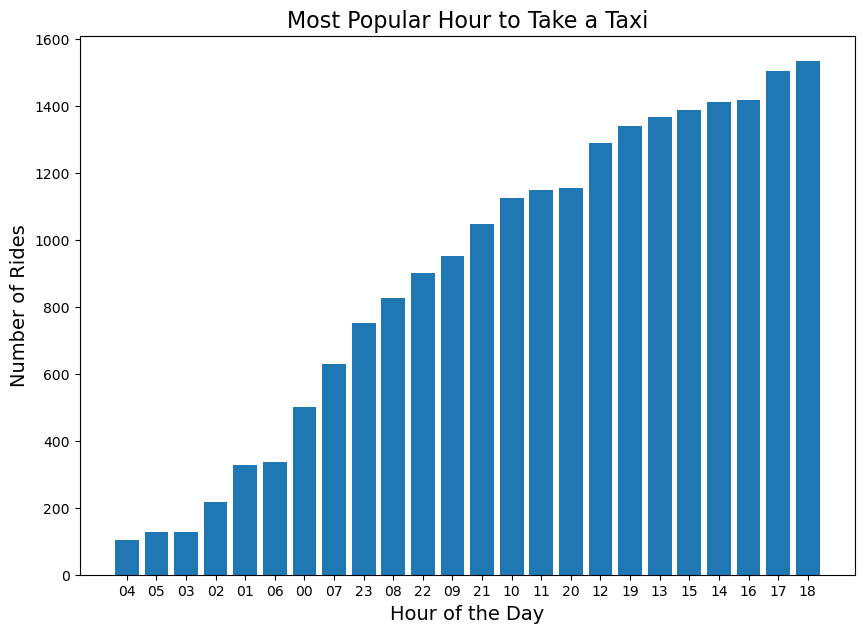

In [64]:
# execute query function and plot

popular_taxi_hour_dataframe = get_data_for_popular_taxi_hour()
popular_taxi_hour(popular_taxi_hour_dataframe)

### Visualization 2: What’s the most popular month to hire a cab or Uber?
August

In [65]:
# define a plot to show average distance travelled by month

def most_popular_month(dataframe):
    
    # Define the figure and axes for the plot
    figure, axes = plt.subplots(figsize=(10, 7))
    
    # order by month
    dataframe["month"] = dataframe["month"].astype(int)
    dataframe = dataframe.sort_values(by="month")
    
    # define values required for the chart - x and y axis and ci
    months = dataframe["month"]
    avg_distances = dataframe["avg_distance"]
    ci_lower = dataframe["ci_lower"]
    ci_upper = dataframe["ci_upper"]
    
    # Line plot with confidence interval
    axes.plot(months, avg_distances, label="Average Distance", marker='o')
    axes.fill_between(months, ci_lower, ci_upper, alpha=0.2, label="90% Confidence Interval")
    
    # Adding labels, title, and styling
    axes.set_title("Average Distance Traveled per Month (2020-2024)", fontsize=16)
    axes.set_xlabel("Month", fontsize=14)
    axes.set_ylabel("Average Distance (miles)", fontsize=14)
    axes.set_xticks(range(len(months)))
    axes.legend(fontsize=8)

    plt.show()

In [66]:
# Combine taxi and uber trips by month. Pull average distance by month from the combined rides

def get_data_for_most_popular_month():
    
    QUERY_2 = """
    WITH CombinedRides AS (
        SELECT 
            strftime('%m', tpep_pickup_datetime) AS month,
            trip_distance AS distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'
        
        UNION ALL
        
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_miles AS distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'
    )
    SELECT 
        month,
        AVG(distance) AS avg_distance,
        COUNT(distance) AS count_distance
    FROM CombinedRides
    GROUP BY month
    ORDER BY month;
    """
    
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_2)).fetchall()
    return pd.DataFrame(results, columns=["month", "avg_distance", "count_distance"])


# function to calculate confidence interval
def calculate_confidence_intervals(dataframe):
    # Assume a 90% confidence interval (Z = 1.645)
    Z = 1.645
    dataframe["ci_lower"] = dataframe["avg_distance"] - Z * (dataframe["avg_distance"] / dataframe["count_distance"]**0.5)
    dataframe["ci_upper"] = dataframe["avg_distance"] + Z * (dataframe["avg_distance"] / dataframe["count_distance"]**0.5)
    return dataframe

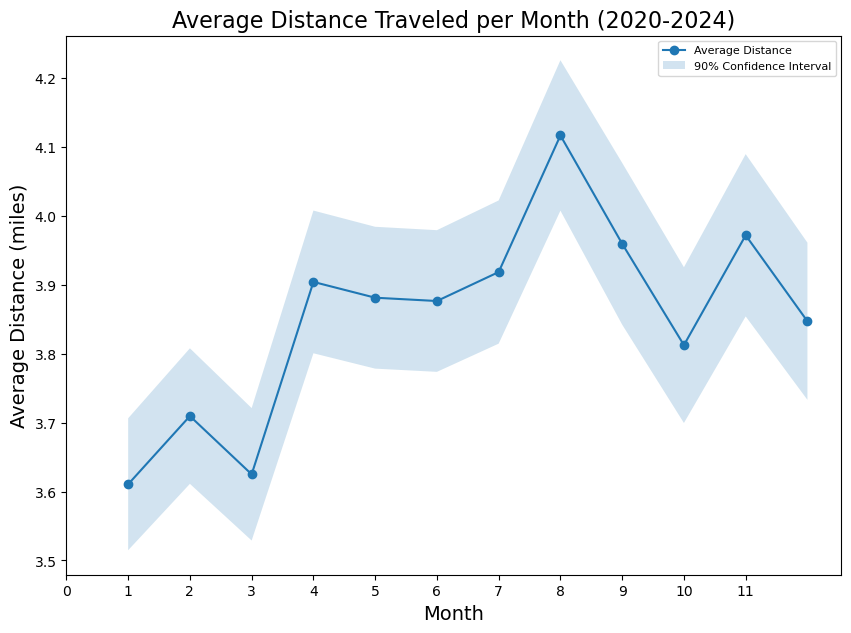

In [67]:
# execute query function and plot
data_for_most_popular_month = get_data_for_most_popular_month()
data_for_most_popular_month = calculate_confidence_intervals(data_for_most_popular_month)
most_popular_month(data_for_most_popular_month)

### Visualization 3 - Which day of the week is most popular for taking a ride to an NYC-based airport?
Sunday


In [68]:
# define a plot to show number of rides by day of the week

def plot_popular_day_to_airport(dataframe):
    
    # Define the figure and axes for the plot
    figure, axes = plt.subplots(figsize=(10, 7))  
    
    # Define mapping of days of the week for readability
    day_mapping = {
        "0": "Sunday",
        "1": "Monday",
        "2": "Tuesday",
        "3": "Wednesday",
        "4": "Thursday",
        "5": "Friday",
        "6": "Saturday"
    }
    
    # Extract airport names and their respective ride counts
    airports = ["LGA", "JFK", "EWR"]
    for airport in airports:
        subset = dataframe[dataframe['airport'] == airport]
        # Sort by day_of_week 
        subset = subset.sort_values(by='day_of_week')
        days = subset['day_of_week'].map(day_mapping)
        ride_counts = subset['ride_count']
        
        # Plot for each airport
        axes.plot(
            days,
            ride_counts,
            label=f"{airport} Airport",
            marker='o'
        )

    # Adding labels, title, and styling
    axes.set_title("Most Popular Day for Airport Drop-offs (2020-2024)", fontsize=14)
    axes.set_xlabel("Day of the Week", fontsize=12)
    axes.set_ylabel("Number of Rides", fontsize=12)
    axes.legend(title="Airports", fontsize=8)
 
    plt.show()

In [69]:
# airport coordinates
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

# Combine taxi and uber rides for drop off destination being LGA, JFK and EWR by day of the week

def popular_day_to_airport_query():

    QUERY_3 = """
    WITH Airports AS (
        SELECT
            *,
            CASE
                WHEN dropoff_latitude BETWEEN 40.763589 AND 40.778865
                     AND dropoff_longitude BETWEEN -73.891745 AND -73.854838 THEN 'LGA'
                WHEN dropoff_latitude BETWEEN 40.639263 AND 40.651376
                     AND dropoff_longitude BETWEEN -73.795642 AND -73.766264 THEN 'JFK'
                WHEN dropoff_latitude BETWEEN 40.686794 AND 40.699680
                     AND dropoff_longitude BETWEEN -74.194028 AND -74.165205 THEN 'EWR'
            END AS airport
        FROM (
            SELECT 
                dropoff_latitude,
                dropoff_longitude,
                strftime('%w', tpep_dropoff_datetime) AS day_of_week,
                'Taxi' AS source
            FROM taxi_trips
            WHERE tpep_dropoff_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'

            UNION ALL

            SELECT 
                dropoff_latitude,
                dropoff_longitude,
                strftime('%w', dropoff_datetime) AS day_of_week,
                'Uber' AS source
            FROM uber_trips
            WHERE dropoff_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'
        )
    )
    SELECT 
        airport,
        day_of_week,
        COUNT(*) AS ride_count
    FROM Airports
    WHERE airport IS NOT NULL
    GROUP BY airport, day_of_week
    ORDER BY airport, day_of_week;
    """

    with engine.connect() as con:
        results = con.execute(db.text(QUERY_3)).fetchall()
    
    return pd.DataFrame(results, columns=["airport", "day_of_week", "ride_count"])

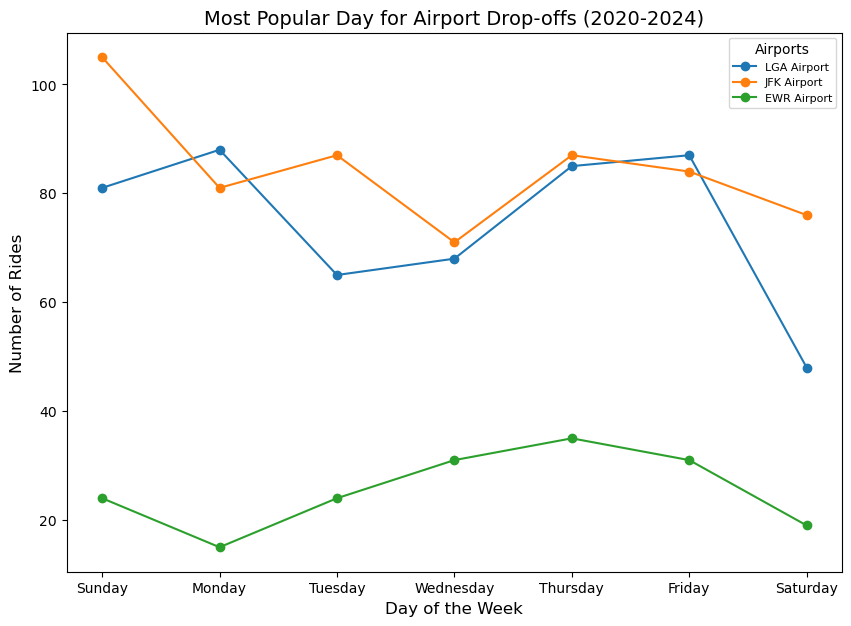

In [70]:
# execute query function and plot

popular_day_to_airport = popular_day_to_airport_query()
plot_popular_day_to_airport(popular_day_to_airport)

### Visualization 4- How much do hired rides earn in total fares monthly?

In [71]:
# Show total fare breakdown by base, surcharges, taxes and tolls by month for uber and taxi rides respectively.

def monthly_earning():

    QUERY_4 = """
    WITH CombinedFares AS (
        SELECT
            strftime('%Y-%m', tpep_pickup_datetime) AS month,
            SUM(fare_amount) AS base_fare,
            SUM(extra + improvement_surcharge + congestion_surcharge + airport_fee) AS surcharges,
            SUM(mta_tax) AS taxes,
            SUM(tolls_amount) AS tolls,
            'Taxi' AS source
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'
        GROUP BY month

        UNION ALL

        SELECT
            strftime('%Y-%m', pickup_datetime) AS month,
            SUM(base_passenger_fare) AS base_fare,
            SUM(congestion_surcharge + bcf + airport_fee) AS surcharges,
            SUM(sales_tax) AS taxes,
            SUM(tolls) AS tolls,
            'Uber' AS source
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2024-08-31 23:59:59'
        GROUP BY month
    )
    SELECT
        month,
        source,
        SUM(base_fare) AS base_fare,
        SUM(surcharges) AS surcharges,
        SUM(taxes) AS taxes,
        SUM(tolls) AS tolls,
        SUM(base_fare + surcharges + taxes + tolls) AS total_fare
    FROM CombinedFares
    GROUP BY month, source
    ORDER BY month, source;
    """
    
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_4)).fetchall()
    return pd.DataFrame(results, columns=["month", "source", "base_fare", "surcharges", "taxes", "tolls", "total_fare"])


In [72]:
# create a stack chart to show monthly earnings by base fare, surcharges and tolls 
# and by month for uber and taxi rides

def plot_monthly_earning(dataframe):
    
    # Prepare data
    dataframe['month'] = pd.to_datetime(dataframe['month'])
    dataframe = dataframe.sort_values(by='month')
    taxi_data = dataframe[dataframe['source'] == 'Taxi']
    uber_data = dataframe[dataframe['source'] == 'Uber']

    # Extract values for plotting
    months = taxi_data['month'].dt.strftime('%Y-%m')
    components = ['base_fare', 'surcharges', 'taxes', 'tolls']

    # Create a grouped bar chart with stacked components
    figure, axes = plt.subplots(figsize=(14, 8))

    bar_width = 0.4
    index = range(len(months))

    for i, component in enumerate(components):
        
        # Stack Taxi and Uber components
        taxi_bottom = taxi_data[components[:i]].sum(axis=1) if i > 0 else 0
        uber_bottom = uber_data[components[:i]].sum(axis=1) if i > 0 else 0

        # Taxi bars
        axes.bar(
            [x - bar_width / 2 for x in index],
            taxi_data[component],
            width=bar_width,
            bottom=taxi_bottom,
            label=f"Taxi - {component.capitalize()}",
            alpha=0.7
        )

        # Uber bars
        axes.bar(
            [x + bar_width / 2 for x in index],
            uber_data[component],
            width=bar_width,
            bottom=uber_bottom,
            label=f"Uber - {component.capitalize()}",
            alpha=0.7
        )

    # Adding labels, title, and styling
    axes.set_title("Monthly Earnings for Hired Rides (2020-2024)", fontsize=16)
    axes.set_xlabel("Month", fontsize=14)
    axes.set_ylabel("Earnings (USD)", fontsize=14)
    axes.set_xticks(index)
    axes.set_xticklabels(months, fontsize=10, rotation=45)
    axes.legend(title="Earning Components", fontsize=10)


    plt.show()

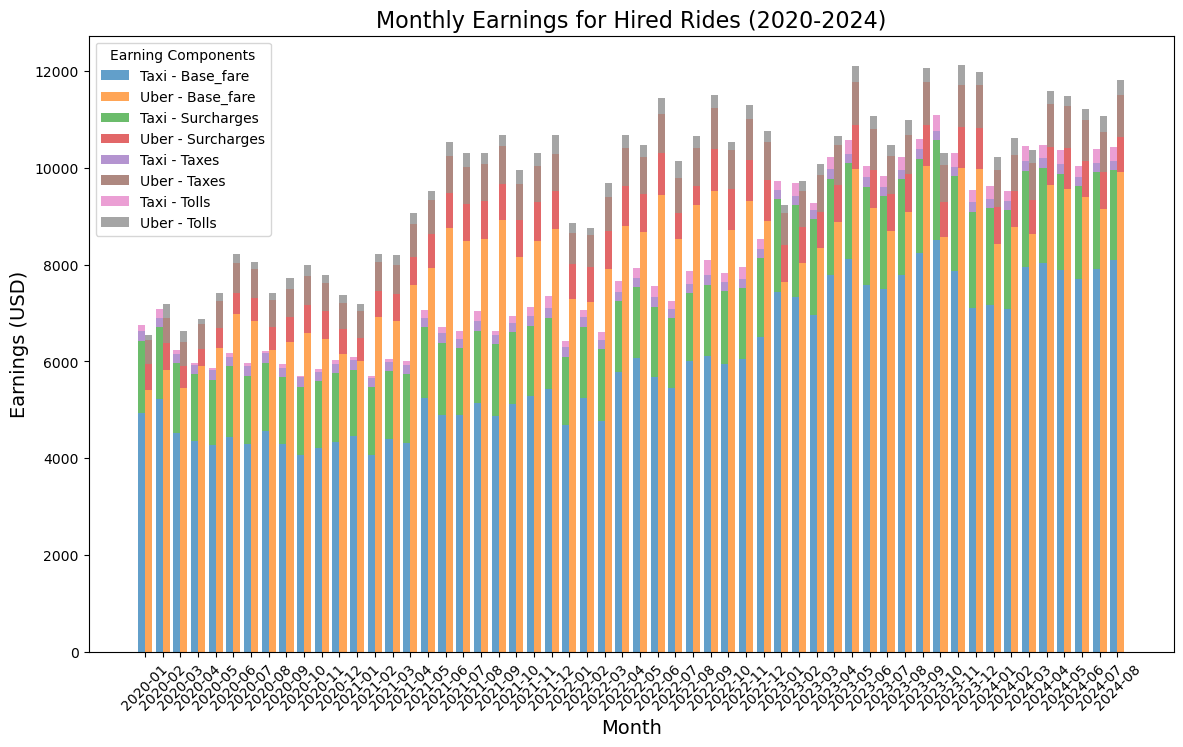

In [73]:
# execute query function and plot

monthly_earning = monthly_earning()
plot_monthly_earning(monthly_earning)

### Visualization 5 - Does precipitation or distance traveled affect the amount of tip?

In [74]:
# create query to:
# 1) compare uber tip amount with distance 
# 2) compare taxi tip amount with distance  
# 3) compare uber tip with precipatation by joining weather and uber tables
# 4) compare taxi tip with precipatation by joining weather and taxi tables

def precipitation_distance_vs_tip():
    QUERY_5 = """
    WITH TaxiFiltered AS (
        SELECT
            trip_distance AS distance,
            tip_amount AS tip,
            d.DailyPrecipitation AS precipitation
        FROM taxi_trips t
        LEFT JOIN daily_weather d
            ON DATE(t.tpep_pickup_datetime) = DATE(d.DATE)
        WHERE t.tpep_pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
          AND trip_distance > 0
          AND tip_amount >= 0
    ),
    UberFiltered AS (
        SELECT
            trip_miles AS distance,
            tips AS tip,
            d.DailyPrecipitation AS precipitation
        FROM uber_trips u
        LEFT JOIN daily_weather d
            ON DATE(u.pickup_datetime) = DATE(d.DATE)
        WHERE u.pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
          AND trip_miles > 0
          AND tips >= 0
    )
    SELECT 'Taxi' AS source, distance, tip, precipitation
    FROM TaxiFiltered
    UNION ALL
    SELECT 'Uber' AS source, distance, tip, precipitation
    FROM UberFiltered;
    """
    # Fetch the data from the database
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_5)).fetchall()
    return pd.DataFrame(results, columns=["source", "distance", "tip", "precipitation"])


In [75]:
def plot_precipitation_distance_vs_tip(dataframe):
    
    # Separate the data by source
    taxi_data = dataframe[dataframe["source"] == "Taxi"]
    uber_data = dataframe[dataframe["source"] == "Uber"]

    # Remove outliers to limit to 95th percentile of distance and tip
    for data in [taxi_data, uber_data]:
        data = data[
            (data["distance"] <= data["distance"].quantile(0.95)) &
            (data["tip"] <= data["tip"].quantile(0.95))
        ]

    # Create the 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Effect of Precipitation and Distance on Tip Amount (2022-2023)", fontsize=16)

    # Plot 1: Taxi - Tip vs Distance
    axes[0, 0].scatter(taxi_data["distance"], taxi_data["tip"])
    axes[0, 0].set_title("Taxi: Tip vs Distance")
    axes[0, 0].set_xlabel("Distance (miles)")
    axes[0, 0].set_ylabel("Tip Amount)")

    # Plot 2: Uber - Tip vs Distance
    axes[0, 1].scatter(uber_data["distance"], uber_data["tip"])
    axes[0, 1].set_title("Uber: Tip vs Distance")
    axes[0, 1].set_xlabel("Distance (miles)")
    axes[0, 1].set_ylabel("Tip Amount")

    # Plot 3: Taxi - Tip vs Precipitation
    axes[1, 0].scatter(taxi_data["precipitation"], taxi_data["tip"])
    axes[1, 0].set_title("Taxi: Tip vs Precipitation")
    axes[1, 0].set_xlabel("Precipitation (inches)")
    axes[1, 0].set_ylabel("Tip Amount")

    # Plot 4: Uber - Tip vs Precipitation
    axes[1, 1].scatter(uber_data["precipitation"], uber_data["tip"])
    axes[1, 1].set_title("Uber: Tip vs Precipitation")
    axes[1, 1].set_xlabel("Precipitation (inches)")
    axes[1, 1].set_ylabel("Tip Amount")

    plt.show()

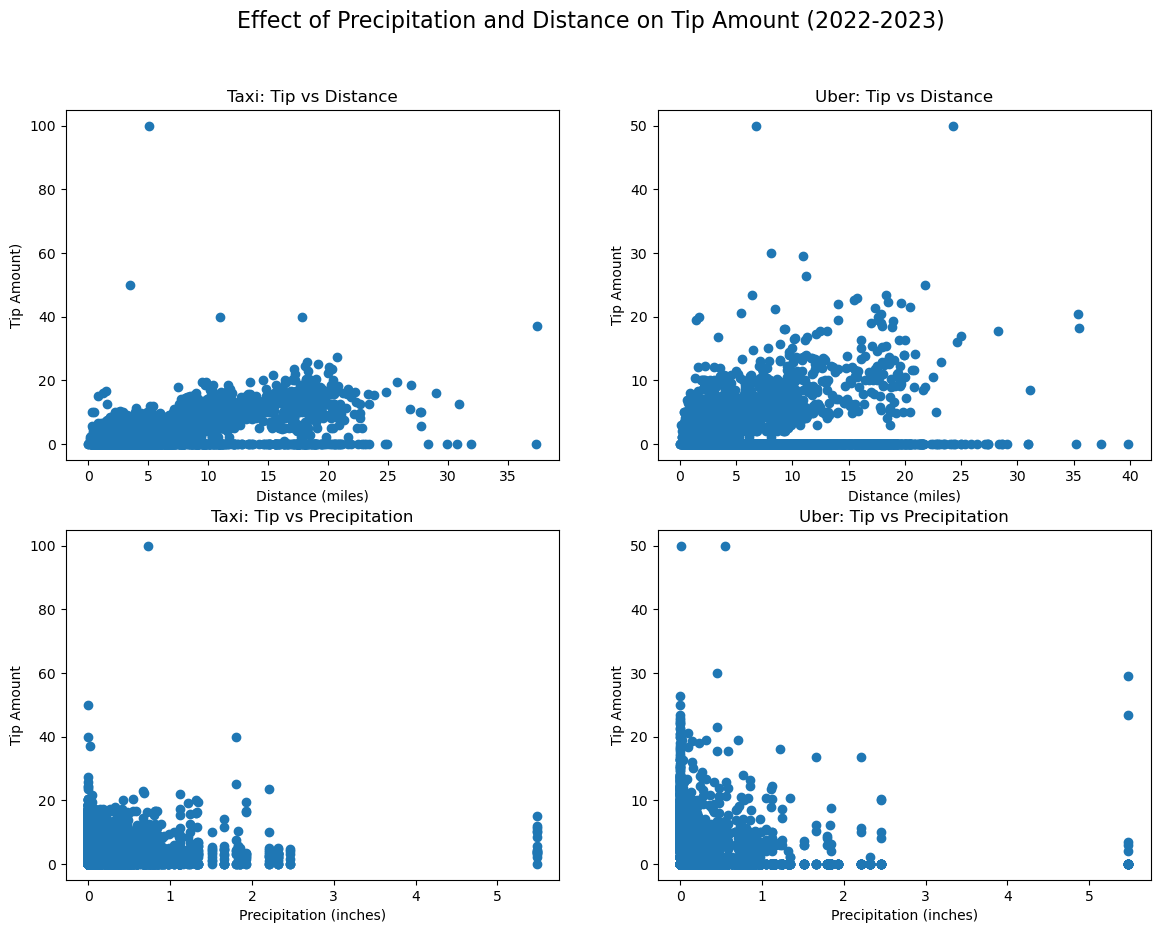

In [76]:
# execute query function and plot
precipitation_distance_vs_tip = precipitation_distance_vs_tip()
plot_precipitation_distance_vs_tip(precipitation_distance_vs_tip)

### Visualization 6 - Create a heatmap of all hired trips in 2020 over a map of the area. 

In [94]:
# plot to create the heatmap for taxi and uber trips in 2020 in New York City

def plot_heatmap_all_trips_2020(dataframe, map_center, output_html):
    
    # Combine pickup and dropoff points into one DataFrame
    combined_data = pd.concat([
        dataframe[['pickup_latitude', 'pickup_longitude']].rename(
            columns={'pickup_latitude': 'latitude', 'pickup_longitude': 'longitude'}),
        dataframe[['dropoff_latitude', 'dropoff_longitude']].rename(
            columns={'dropoff_latitude': 'latitude', 'dropoff_longitude': 'longitude'})
    ], ignore_index=True)
    
    # Drop missing values
    combined_data = combined_data.dropna(subset=['latitude', 'longitude'])

    # Filter data to focus on NYC area
    nyc_bbox = {
        "min_lat": 40.560445,
        "max_lat": 40.908524,
        "min_lon": -74.242330,
        "max_lon": -73.717047,
    }
    filtered_data = combined_data[
        (combined_data['latitude'].between(nyc_bbox['min_lat'], nyc_bbox['max_lat'])) &
        (combined_data['longitude'].between(nyc_bbox['min_lon'], nyc_bbox['max_lon']))
    ]

    # Prepare data for the heatmap
    heat_data = filtered_data[['latitude', 'longitude']].values.tolist()

    # Create a Folium map
    m = folium.Map(location=map_center, zoom_start=12)

    # Add a heatmap layer
    HeatMap(heat_data, radius=8, blur=10, max_zoom=12).add_to(m)

    # Save map to HTML file
    m.save(output_html)
    print(f"Heatmap saved to {output_html}")

    return m

In [95]:
# combine uber and taxi trips in 2020

def heatmap_all_trips_2020():
    QUERY_6 = """
    SELECT 
        pickup_latitude, 
        pickup_longitude, 
        dropoff_latitude, 
        dropoff_longitude 
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2020-12-31 23:59:59'
    UNION ALL
    SELECT 
        pickup_latitude, 
        pickup_longitude, 
        dropoff_latitude, 
        dropoff_longitude 
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2020-01-01 00:00:00' AND '2020-12-31 23:59:59'
    """
    
    # Connect to database and fetch data
    with engine.connect() as con:
        results = con.execute(db.text(QUERY_6)).fetchall()
    trip_data = pd.DataFrame(results, columns=["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])
    return trip_data

In [97]:
# Create the heatmap
trip_data = heatmap_all_trips_2020()
nyc_center = (40.7128, -74.0060)  # Approximate center of NYC
output_file = "nyc_heatmap_2020.html"
plot_heatmap_all_trips_2020(trip_data, nyc_center, output_file)

Heatmap saved to nyc_heatmap_2020.html


### Extra credit: Do majority of the uber rides happen before or after sunset?

In [85]:
# create a daily sun times table with date, sunset and sunrise columns from daily_weather_data

def create_daily_sun_times_table(engine, daily_weather_data):
    """
    Create a SQL table for daily sunrise and sunset times from weather data.
    """
    daily_weather_data[['DATE', 'Sunrise', 'Sunset']].to_sql(
        'daily_sun_times',
        con=engine,
        if_exists='replace',
        index=False,
        dtype={
            'DATE': db.types.Date,
            'Sunrise': db.types.Time,
            'Sunset': db.types.Time,
        }
    )

In [86]:
# SQL Query for Uber rides categorized by time of day
QUERY_UBER_BEFORE_AFTER_SUNSET = """
WITH UberWithSunTimes AS (
    SELECT 
        u.pickup_datetime,
        DATE(u.pickup_datetime) AS ride_date,
        CASE 
            WHEN TIME(u.pickup_datetime) < TIME(w.Sunrise) THEN 'Before Sunrise'
            WHEN TIME(u.pickup_datetime) > TIME(w.Sunset) THEN 'After Sunset'
            ELSE 'Daytime'
        END AS time_period
    FROM uber_trips u
    JOIN daily_sun_times w
    ON DATE(u.pickup_datetime) = w.DATE
)
SELECT 
    time_period,
    COUNT(*) AS ride_count
FROM UberWithSunTimes
GROUP BY time_period
ORDER BY ride_count DESC;
"""

In [87]:
# define function to get ride counts by time period
def get_uber_time_period_data(engine):

    with engine.connect() as con:
        results = con.execute(db.text(QUERY_UBER_BEFORE_AFTER_SUNSET)).fetchall()
    return pd.DataFrame(results, columns=["time_period", "ride_count"])

In [88]:
# Visualize the Uber ride counts categorized by time periods using bar chart.
   
def plot_uber_time_period(dataframe):
    """
    Visualize the Uber ride counts categorized by time periods.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(dataframe['time_period'], dataframe['ride_count'], color=['#4CAF50', '#FF5733', '#1E90FF'])

    ax.set_title("Uber Rides Before Sunrise, After Sunset, and During Daytime", fontsize=16)
    ax.set_xlabel("Time Period", fontsize=14)
    ax.set_ylabel("Number of Rides", fontsize=14)

    plt.show()

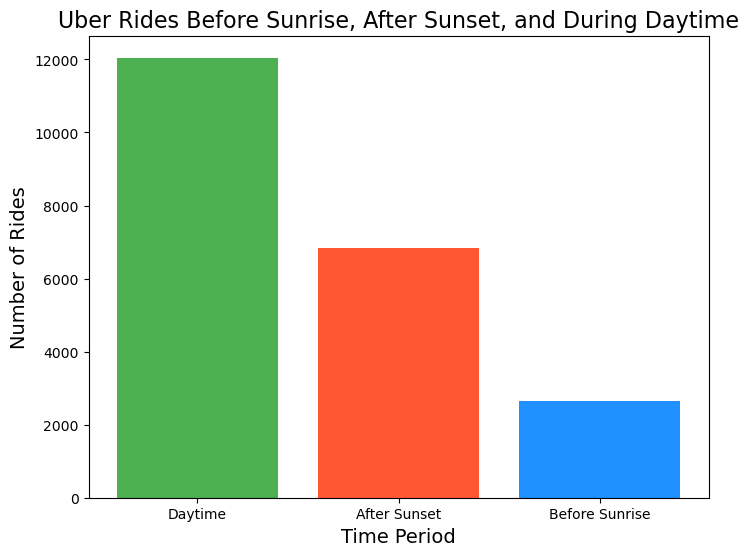

In [89]:
# Create the daily_sun_times table
create_daily_sun_times_table(engine, daily_weather_data)

# Step 2: Execute the query to get ride counts
uber_time_period_df = get_uber_time_period_data(engine)

#  Plot the results
plot_uber_time_period(uber_time_period_df)